# CIS400 Data Mining Assignment 2
## a small social network based on the Twitter API and networkx package
## I'm currently working with three students for our final team project.

## Login

In [7]:
import twitter
import json

CONSUMER_KEY = '' #API key
CONSUMER_SECRET = '' #API secret key
OAUTH_TOKEN = '' #Access Token Open authorization
OAUTH_TOKEN_SECRET = '' #Access Token secret

auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET) #Constructor using these four info

twitter_api = twitter.Twitter(auth=auth)

print(twitter_api)

## Find Users

In [8]:
response = twitter_api.users.search(q = 'edmund yu') 
#print(json.dumps(response, sort_keys = True, indent =/ 4))
for i in response:
    try:
        print(i['name'], i['screen_name'], i['id'])
    except:
        pass
user_name = "Edmund Yu"
user_screen_name = "edmundyu1001" #"my professor's name"
user_id = 165035772
#Edmund Yu edmundyu1001 165035772

Edmund.D.Yu EdmuntYu 933222609432363008
Edmund Yu Deliezo e_edmund 594277651
Edmund Tay Yu Xiang etyxetyx 970573350
Edmund Lee EdmundChunYuLee 1034325950391934976
edmund yu tan djedmund92 51919173
Edmund.D.Yu EdmundDYu1 1212210342123585536
edmund yu edmundyangyang 847040585911287808
Edmund Yu Edmund_YS 882186321791377409
Edmund Yu edmundyu1001 165035772
EdmundYu EdmundYu1 4329400583
Edmund Yu SF_Ed 1000291795
Edmund Yu 5ayknivesfa 312016573
Edmund Yu aznxedxboy8181 738601804896735232
Edmund Yu EdmundYu3 1031585357085716480
Edmund Yu EdmundYu4 1326736985906581505
Edmund Yu ed_mnnd 28505763
Benedict.Yu EdmundYu0 984271488399196160
Charles Yu YuEdmund 1809829050
Edmund Yu EdmundYu 479905469
Edmund Yu RazielXIII 275977722


## Functions (From course materials)

In [9]:
import sys
import time
from urllib.error import URLError
from http.client import BadStatusLine
import json
import twitter
from functools import partial
from sys import maxsize as maxint

def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,  
                              friends_limit=maxint, followers_limit=maxint):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # See http://bit.ly/2GcjKJP and http://bit.ly/2rFz90N for details
    # on API parameters
    
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids, 
                              count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids, 
                                count=5000)

    friends_ids, followers_ids = [], []
    
    for twitter_api_func, limit, ids, label in [
                    [get_friends_ids, friends_limit, friends_ids, "friends"], 
                    [get_followers_ids, followers_limit, followers_ids, "followers"]
                ]:
        
        if limit == 0: continue
        
        cursor = -1
        while cursor != 0:
        
            # Use make_twitter_request via the partially bound callable...
            if screen_name: 
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)

            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
        
            print('Fetched {0} total {1} ids for {2}'.format(len(ids),\
                  label, (user_id or screen_name)),file=sys.stderr)
        
            # XXX: You may want to store data during each iteration to provide an 
            # an additional layer of protection from exceptional circumstances
        
            if len(ids) >= limit or response is None:
                break

    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 

    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
    
        # See https://developer.twitter.com/en/docs/basics/response-codes
        # for common codes
    
        if e.e.code == 401:
            print('Encountered 401 Error (Not Authorized)', file=sys.stderr)
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429: 
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered {0} Error. Retrying in {1} seconds'\
                  .format(e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError as e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print("BadStatusLine encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
                
def get_user_profile(twitter_api, screen_names=None, user_ids=None): 
   
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None), \
    "Must have screen_names or user_ids, but not both"
    
    items_to_info = {}

    items = screen_names or user_ids
    
    while len(items) > 0:

        # Process 100 items at a time per the API specifications for /users/lookup.
        # See http://bit.ly/2Gcjfzr for details.
        
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]

        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup, 
                                            screen_name=items_str)
        else: # user_ids
            response = make_twitter_request(twitter_api.users.lookup, 
                                            user_id=items_str)
    
        for user_info in response:
            if screen_names:
                items_to_info[user_info['screen_name']] = user_info
            else: # user_ids
                items_to_info[user_info['id']] = user_info

    return items_to_info

def get_reciprocal_friends(twitter_api, user_id = None):  # find reciprocal friends
    friends_ids, followers_ids = get_friends_followers_ids(twitter_api, 
                                                       user_id=user_id, 
                                                       friends_limit=5000,   
                                                       followers_limit=5000)
    reciprocal_friends_ids = list(set(friends_ids) & set(followers_ids))
    return reciprocal_friends_ids

def popular_reciprocal_friends(twitter_api, user_id = None, count = 5): # filter top 5 popular reciprocal friends
    reciprocal_friends_ids = get_reciprocal_friends(twitter_api, user_id)
    if len(reciprocal_friends_ids) < count: # shortcuts for reciprocal friends < 5
        return reciprocal_friends_ids
    else:
        response = get_user_profile(twitter_api, user_ids = reciprocal_friends_ids)
        reciprocal_friends_dict = {id:response[id]['followers_count'] for id in response.keys()}
        sorted_reciprocal_friends =  sorted(reciprocal_friends_dict, key = reciprocal_friends_dict.get, reverse = True)
    return sorted_reciprocal_friends[:count]

Fetched 133 total friends ids for 165035772
Fetched 99 total followers ids for 165035772


Got Followers for edmundyu1001:[17881816, 1933042237, 14645160, 76966092, 5514192]


Fetched 5000 total friends ids for 17881816
Fetched 5000 total followers ids for 17881816


Got followers for 17881816:[606412878, 32338228, 3403573407, 23139997, 199565541]
[606412878, 32338228, 3403573407, 23139997, 199565541]
7
8
9
10
11


Fetched 5000 total friends ids for 1933042237
Fetched 5000 total followers ids for 1933042237


Got followers for 1933042237:[102171978, 897506675418165248, 20819690, 553172586, 1009459519846473728]
[102171978, 897506675418165248, 20819690, 553172586, 1009459519846473728]
12
13
14
15
16


Fetched 5000 total friends ids for 14645160
Fetched 5000 total followers ids for 14645160


Got followers for 14645160:[42345999, 16344329, 214337395, 18512945, 21687766]
[42345999, 16344329, 214337395, 18512945, 21687766]
17
18
19
20
21


Fetched 5000 total friends ids for 76966092
Fetched 5000 total followers ids for 76966092


Got followers for 76966092:[159869411, 836531888, 1256377525, 1617549211, 2837608628]
[159869411, 836531888, 1256377525, 1617549211, 2837608628]
22
23
24
25
26


Fetched 5000 total friends ids for 5514192
Fetched 5000 total followers ids for 5514192


Got followers for 5514192:[26637348, 422377883, 1256377525, 142512127, 2250233750]
[26637348, 422377883, 1256377525, 142512127, 2250233750]
27
28
29
30


Fetched 5000 total friends ids for 606412878
Fetched 5000 total followers ids for 606412878


Got followers for 606412878:[419107960, 89014429, 3840, 2730745332, 57893062]
[419107960, 89014429, 3840, 2730745332, 57893062]
31
32
33
34
35


Fetched 5000 total friends ids for 32338228
Fetched 5000 total followers ids for 32338228


Got followers for 32338228:[17881816, 57982473, 96082963, 66306024, 18500852]
[17881816, 57982473, 96082963, 66306024, 18500852]
36
37
38
39


Fetched 121 total friends ids for 3403573407
Fetched 5000 total followers ids for 3403573407


Got followers for 3403573407:[24929621, 141664648, 17881816, 14645160, 21360280]
[24929621, 141664648, 17881816, 14645160, 21360280]
40
41
42


Fetched 3127 total friends ids for 23139997
Fetched 4517 total followers ids for 23139997


Got followers for 23139997:[17881816, 171337448, 872695783, 19569136, 22018221]
[17881816, 171337448, 872695783, 19569136, 22018221]
43
44
45
46


Fetched 1191 total friends ids for 199565541
Fetched 3699 total followers ids for 199565541


Got followers for 199565541:[17881816, 200932969, 54649261, 149103331, 153492935]
[17881816, 200932969, 54649261, 149103331, 153492935]
47
48
49
50


Fetched 1337 total friends ids for 102171978
Fetched 4757 total followers ids for 102171978


Got followers for 102171978:[17093617, 15808765, 63796828, 17525171, 87403396]
[17093617, 15808765, 63796828, 17525171, 87403396]
51
52
53
54
55


Fetched 1588 total friends ids for 897506675418165248
Fetched 4249 total followers ids for 897506675418165248


Got followers for 897506675418165248:[1933042237, 20756169, 20882981, 1854401, 65563900]
[1933042237, 20756169, 20882981, 1854401, 65563900]
56
57
58
59


Fetched 1954 total friends ids for 20819690
Fetched 3142 total followers ids for 20819690


Got followers for 20819690:[17093617, 37599351, 17525171, 17881816, 1933042237]
[17093617, 37599351, 17525171, 17881816, 1933042237]
60


Fetched 942 total friends ids for 553172586
Fetched 737 total followers ids for 553172586
Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


Got followers for 553172586:[1933042237, 14645160, 42070873, 82329216, 1689338184]
[1933042237, 14645160, 42070873, 82329216, 1689338184]
61
62
63


...ZzZ...Awake now and trying again.
Fetched 745 total friends ids for 1009459519846473728
Fetched 706 total followers ids for 1009459519846473728


Got followers for 1009459519846473728:[1933042237, 14645160, 75051887, 892275857779118080, 16529873]
[1933042237, 14645160, 75051887, 892275857779118080, 16529873]
64
65
66


Fetched 2348 total friends ids for 42345999
Fetched 5000 total followers ids for 42345999


Got followers for 42345999:[168778996, 14645160, 153252061, 15433452, 20641934]
[168778996, 14645160, 153252061, 15433452, 20641934]
67
68
69
70


Fetched 784 total friends ids for 16344329
Fetched 5000 total followers ids for 16344329


Got followers for 16344329:[2228878592, 14645160, 23494080, 14298769, 892275857779118080]
[2228878592, 14645160, 23494080, 14298769, 892275857779118080]
71
72
73


Fetched 2716 total friends ids for 214337395
Fetched 5000 total followers ids for 214337395


Got followers for 214337395:[14989516, 1298358020339048449, 22124289, 2693401014, 124040470]
[14989516, 1298358020339048449, 22124289, 2693401014, 124040470]
74
75
76
77
78


Fetched 5000 total friends ids for 18512945
Fetched 5000 total followers ids for 18512945


Got followers for 18512945:[141664648, 14645160, 286773713, 23494080, 494588158]
[141664648, 14645160, 286773713, 23494080, 494588158]
79
80


Fetched 1345 total friends ids for 21687766
Fetched 5000 total followers ids for 21687766


Got followers for 21687766:[14645160, 2729061, 145741832, 21212087, 633980404]
[14645160, 2729061, 145741832, 21212087, 633980404]
81
82
83
84


Encountered 401 Error (Not Authorized)
Fetched 0 total friends ids for 159869411
Encountered 401 Error (Not Authorized)
Fetched 0 total followers ids for 159869411


159869411is protected


Encountered 401 Error (Not Authorized)
Fetched 0 total friends ids for 836531888
Encountered 401 Error (Not Authorized)
Fetched 0 total followers ids for 836531888


836531888is protected


Fetched 408 total friends ids for 1256377525
Fetched 1655 total followers ids for 1256377525


Got followers for 1256377525:[37599351, 87403396, 171337448, 76966092, 37836873]
[37599351, 87403396, 171337448, 76966092, 37836873]
85


Fetched 2351 total friends ids for 1617549211
Fetched 891 total followers ids for 1617549211


Got followers for 1617549211:[37599351, 17881816, 76966092, 19977431, 3312173903]
[37599351, 17881816, 76966092, 19977431, 3312173903]
86
87


Fetched 1122 total friends ids for 2837608628
Fetched 791 total followers ids for 2837608628


Got followers for 2837608628:[38802447, 76966092, 1406619086, 25458378, 3078942992]
[38802447, 76966092, 1406619086, 25458378, 3078942992]
88
89
90
91


Fetched 2590 total friends ids for 26637348
Fetched 5000 total followers ids for 26637348
Encountered 401 Error (Not Authorized)
Fetched 0 total friends ids for 422377883


26637348is protected


Encountered 401 Error (Not Authorized)
Fetched 0 total followers ids for 422377883
Encountered 401 Error (Not Authorized)
Fetched 0 total friends ids for 142512127


422377883is protected


Encountered 401 Error (Not Authorized)
Fetched 0 total followers ids for 142512127


142512127is protected


Fetched 3227 total friends ids for 2250233750
Fetched 926 total followers ids for 2250233750
Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


Got followers for 2250233750:[151198065, 3078942992, 5514192, 20132655, 216998174]
[151198065, 3078942992, 5514192, 20132655, 216998174]
92
93
94


...ZzZ...Awake now and trying again.
Fetched 1559 total friends ids for 419107960
Fetched 5000 total followers ids for 419107960


419107960is protected


Fetched 5000 total friends ids for 89014429
Fetched 5000 total followers ids for 89014429


Got followers for 89014429:[1355585256, 925102599505715200, 38559894, 3030757183]
[1355585256, 925102599505715200, 38559894, 3030757183]
95
96
97
98


Fetched 4468 total friends ids for 3840
Fetched 5000 total followers ids for 3840


Got followers for 3840:[52529896, 606412878, 2281325286, 40779444, 872423437]
[52529896, 606412878, 2281325286, 40779444, 872423437]
99
100
101
102


Fetched 5000 total friends ids for 2730745332
Fetched 5000 total followers ids for 2730745332


Number of Nodes = 102
Number of Edges = 101
Node list = [165035772, 17881816, 1933042237, 14645160, 76966092, 5514192, 606412878, 32338228, 3403573407, 23139997, 199565541, 102171978, 897506675418165248, 20819690, 553172586, 1009459519846473728, 42345999, 16344329, 214337395, 18512945, 21687766, 159869411, 836531888, 1256377525, 1617549211, 2837608628, 26637348, 422377883, 142512127, 2250233750, 419107960, 89014429, 3840, 2730745332, 57893062, 57982473, 96082963, 66306024, 18500852, 24929621, 141664648, 21360280, 171337448, 872695783, 19569136, 22018221, 200932969, 54649261, 149103331, 153492935, 17093617, 15808765, 63796828, 17525171, 87403396, 20756169, 20882981, 1854401, 65563900, 37599351, 42070873, 82329216, 1689338184, 75051887, 892275857779118080, 16529873, 168778996, 153252061, 15433452, 20641934, 2228878592, 23494080, 14298769, 14989516, 1298358020339048449, 22124289, 2693401014, 124040470, 286773713, 494588158, 2729061, 145741832, 21212087, 633980404, 37836873, 19977431, 3312

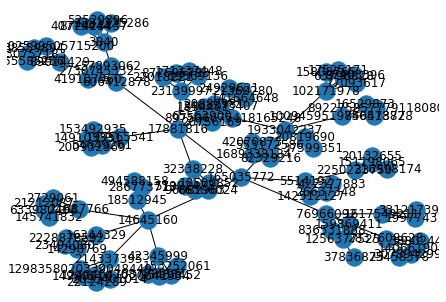

Diameter of the network: 7
Average distance of the network: 4.878858474082702


In [10]:
import networkx as nx
G = nx.Graph() # create a graph
response = make_twitter_request(popular_reciprocal_friends, twitter_api = twitter_api, user_id = user_id)
ids = [user_id]
next_queue = response
print("Got Followers for {0}:{1}".format(user_screen_name, next_queue))
ids += next_queue

G.add_nodes_from(ids)
for i in next_queue:
    G.add_edge(ids[0],i)

depth = 1
max_depth = 4

while depth < max_depth:
    if G.number_of_nodes() > 100:
        break
    depth += 1
    (queue, next_queue) = (next_queue, [])
    for id in queue:
        response = make_twitter_request(popular_reciprocal_friends, twitter_api = twitter_api, user_id = id)
        if G.number_of_nodes() > 100:
            break 
        elif response:
            print("Got followers for {0}:{1}".format(id, response))
            print(response)
            for i in response:
                if (i not in next_queue and i not in ids):
                    next_queue.append(i)
                    G.add_node(i)
                    G.add_edge(id, i)
                    print(G.number_of_nodes())
        else:
            print(str(id) + 'is protected')
    ids += next_queue
    

print("Number of Nodes = {0}".format(G.number_of_nodes()))
print("Number of Edges = {0}".format(G.number_of_edges()))
print("Node list = {0}".format(G.nodes()))
print("Edge list = {0}".format(G.edges()))

import matplotlib.pyplot as plt
nx.draw(G,with_labels = True)
plt.savefig("mygraph.png")
plt.show()
print("Diameter of the network:", nx.diameter(G))
print("Average distance of the network:", nx.average_shortest_path_length(G))